In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

width = 12
height = 7
plt.rcParams["figure.figsize"] = (width, height)

import numpy as np
import pandas as pd
import pickle
import tflscripts
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import itertools

configuration = tflscripts.read_configuration()

In [2]:
df_results = pd.read_pickle('results_with_accuracy_classified.p')
df_results = df_results.loc[df_results.specificity >= 0.95]
df_results = df_results.loc[(df_results.predictions == 1)]
df_results = df_results.loc[df_results.type_of_transfer != 'No transfer']

In [3]:
def key_for_test(source_dataset,
                    source_device,
                    target_dataset,
                    target_device,
                    label,
                    features,
                    classifier):
    return source_dataset + source_device + target_dataset + target_device + \
        label + features + classifier

def key_for_result_row(row):
    return key_for_test(source_dataset=row['source_dataset'],
                       source_device=row['source_device'],
                       target_dataset=row['target_dataset'],
                       target_device=row['target_device'],
                       label=row['label'],
                       features=row['features'],
                       classifier=row['classifier'])

def key_for_test_result(result):
    return key_for_test(source_dataset=result.source_dataset,
                       source_device=result.source_device,
                       target_dataset=result.target_dataset,
                       target_device=result.target_device,
                       label=result.label_name(),
                       features=result.features,
                       classifier=result.classifier)

def test_results_for_df(df_results):
    wanted_test_results = {}
    for i, row in df_results.iterrows():
        key = key_for_result_row(row)
        wanted_test_results[key] = i

    found_test_results = {}
    for dataset in configuration['device_roles']:
        for device in configuration['device_roles'][dataset]:
            test_set = tflscripts.TestSet(name='_'.join([dataset, device]))
            if test_set.exists():
                for result in test_set.get_results():
                    key = key_for_test_result(result)
                    if key in wanted_test_results:
                        result_row_id = wanted_test_results[key]
                        found_test_results[result_row_id] = result

    return found_test_results

def filter_results_by_accuracy(case_results, accuracy_column):
    label_models = {}
    for i, row_result in case_results.iterrows():
        label = row_result['label']
        if label in label_models:
            other_row_result = case_results.loc[case_results.index == label_models[label]].iloc[0]
            if other_row_result[accuracy_column] < row_result[accuracy_column]:
                label_models[label] = i
        else:
            label_models[label] = i

    result_ids = list(label_models.values())
    return result_ids

def majority_vote(row):
    value_counts = row.value_counts()
    value_counts = value_counts[value_counts.index != -1]
    if len(value_counts) == 0:
        return -1
    return value_counts.idxmax()

In [4]:
cases = df_results[['target_device', 'target_dataset']].drop_duplicates()
cases.columns = ['device', 'dataset']
all_test_results = test_results_for_df(df_results)

In [5]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation='vertical')
    plt.yticks(tick_marks, classes)

    non_normalized = cm
    if normalize:
        cm = np.nan_to_num(np.round(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], 2))

#     print(cm)

    thresh = non_normalized.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if non_normalized[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

synergy-final-iter5 128.237.227.76 0.774390243902 0.960043196544


/home/giotto/.local/lib/python3.5/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in true_divide


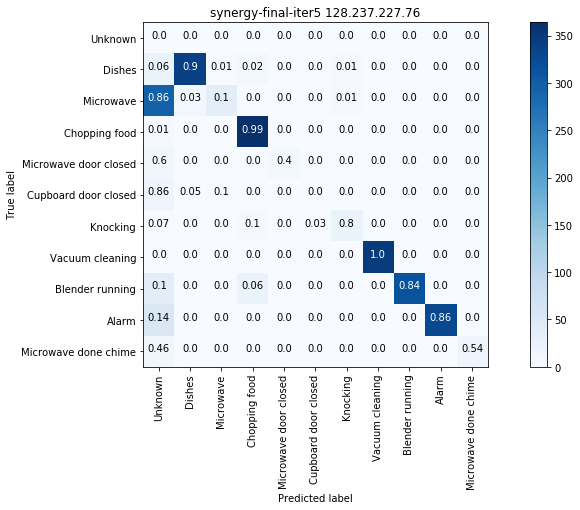

synergy-final-iter4 128.237.250.218 11 MICROPHONE_|microphone SVM
synergy-final-iter4 128.237.250.218 22 MICROPHONE_|microphone RandomForestClassifier
synergy-final-iter4 128.237.250.218 23 .* SVM
synergy-final-iter4 128.237.250.218 7 MICROPHONE_|microphone LogisticRegression
synergy-final-iter4 128.237.250.218 0 MICROPHONE_|microphone SVM
synergy-final-iter4 128.237.250.218 25 MICROPHONE_|microphone LogisticRegression
synergy-final-iter2 128.237.254.195 1 MICROPHONE_|microphone SVM
synergy-final-iter4 128.237.250.218 21 .* RandomForestClassifier
synergy-final-iter4 128.237.250.218 18 ACCEL_|accel_|mag_ LogisticRegression
synergy-final-iter4 128.237.250.218 13 MICROPHONE|microphone|ACCEL_|accel_ RandomForestClassifier

synergy-final-iter1 128.237.254.195 0.794949494949 0.893303064699


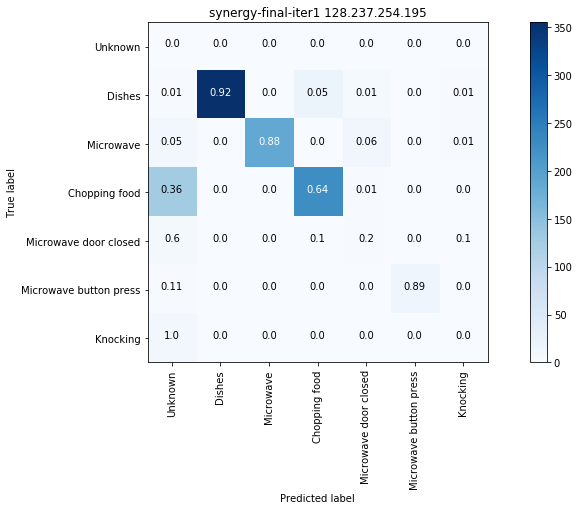

synergy-final-iter2 128.237.248.186 11 .* LogisticRegression
synergy-final-iter5 128.237.250.218 7 MICROPHONE_|microphone LogisticRegression
scott-final-iter1 128.237.247.134 0 MICROPHONE_|microphone LogisticRegression
synergy-final-iter5 128.237.250.218 1 MICROPHONE_|microphone SVM
synergy-final-iter2 128.237.248.186 18 MICROPHONE|microphone|ACCEL_|accel_ LogisticRegression
synergy-final-iter1 128.237.248.186 14 MICROPHONE_|microphone SVM

synergy-final-iter4 128.237.250.218 0.86960950764 0.962058602554


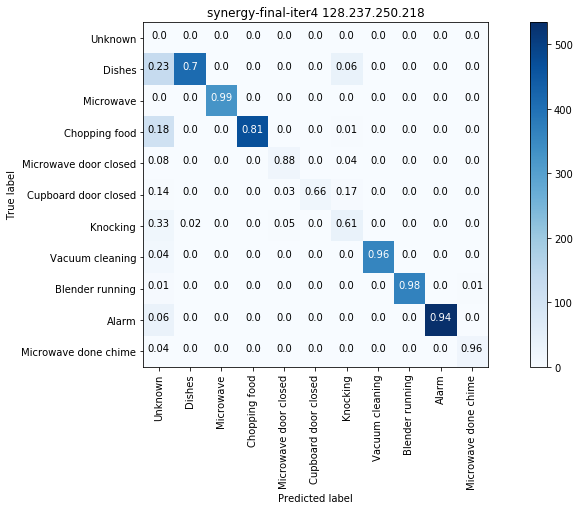

synergy-final-iter5 128.237.250.218 21 MICROPHONE|microphone|ACCEL_|accel_ RandomForestClassifier
synergy-final-iter5 128.237.250.218 23 .* SVM
synergy-final-iter5 128.237.227.76 0 MICROPHONE_|microphone SVM
synergy-final-iter5 128.237.227.76 7 MICROPHONE_|microphone RandomForestClassifier
synergy-final-iter5 128.237.227.76 11 MICROPHONE_|microphone LogisticRegression
synergy-final-iter5 128.237.227.76 25 MICROPHONE_|microphone SVM
synergy-final-iter5 128.237.227.76 1 MICROPHONE_|microphone SVM
synergy-final-iter4 128.237.247.190 22 .* SVM
synergy-final-iter2 128.237.254.195 18 MICROPHONE|microphone|ACCEL_|accel_ LogisticRegression
synergy-final-iter5 128.237.227.76 13 MICROPHONE_|microphone SVM

scott-final-iter1 128.237.247.134 0.814266487214 0.916666666667


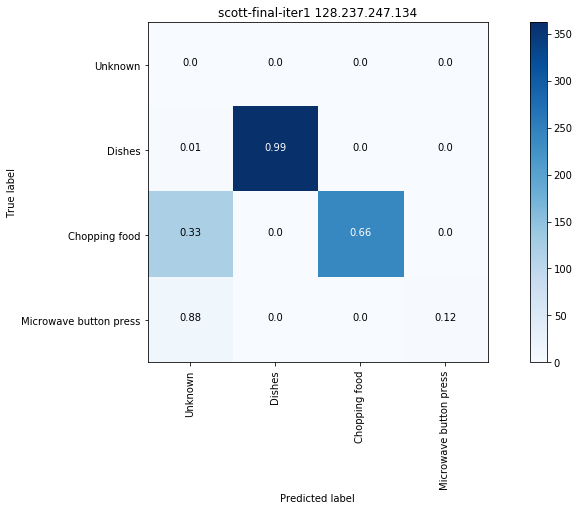

robotics-final 128.237.246.127 0 MICROPHONE|microphone|ACCEL_|accel_ LogisticRegression
scott-final-iter1 128.237.248.186 14 MICROPHONE_|microphone SVM
synergy-final-iter5 128.237.227.76 7 MICROPHONE_|microphone SVM

robotics-final 128.237.246.127 0.957446808511 0.989010989011


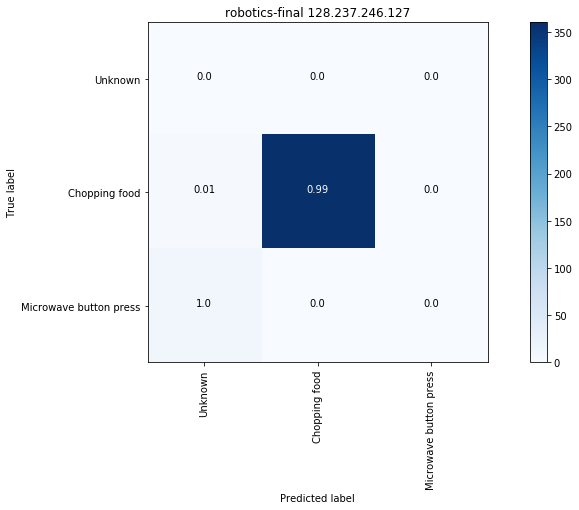

scott-final-iter1 128.237.247.134 14 MICROPHONE_|microphone LogisticRegression
robotics-final 128.237.247.134 7 MICROPHONE_|microphone LogisticRegression

robotics-final 128.237.247.134 0.912043301759 0.859693877551


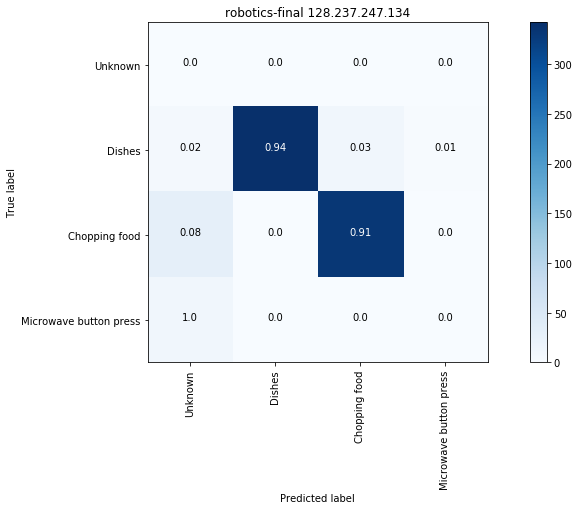

robotics-final 128.237.246.127 0 MICROPHONE_|microphone LogisticRegression
scott-final-iter1 128.237.247.134 14 MICROPHONE_|microphone LogisticRegression
synergy-final-iter4 128.237.250.218 7 MICROPHONE_|microphone LogisticRegression

scott-final-iter1 128.237.248.186 0.781986531987 0.899322362052


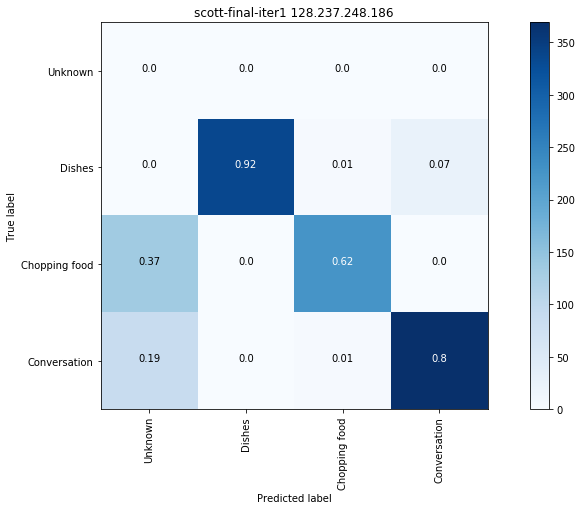

robotics-final 128.237.247.134 0 MICROPHONE|microphone|ACCEL_|accel_ LogisticRegression
synergy-final-iter1 128.237.254.195 8 .* LogisticRegression
synergy-final-iter5 128.237.250.218 7 .* LogisticRegression

synergy-final-iter1 128.237.248.186 0.560052219321 0.75


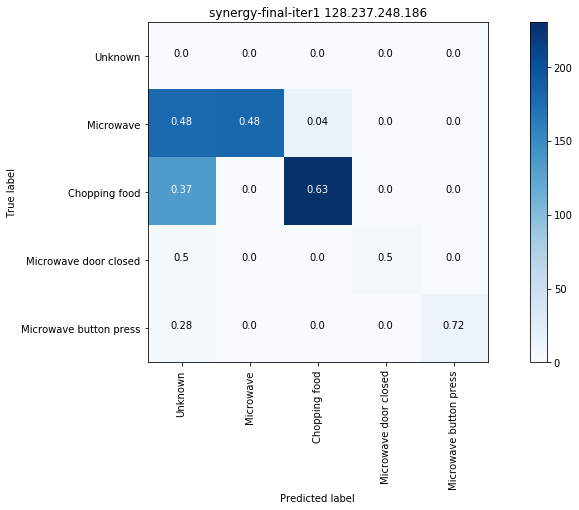

synergy-final-iter4 128.237.247.190 11 MICROPHONE_|microphone LogisticRegression
synergy-final-iter2 128.237.248.186 1 MICROPHONE_|microphone SVM
scott-final-iter1 128.237.248.186 14 MICROPHONE_|microphone LogisticRegression
synergy-final-iter5 128.237.250.218 7 .* LogisticRegression

synergy-final-iter2 128.237.248.186 0.802389705882 0.883603238866


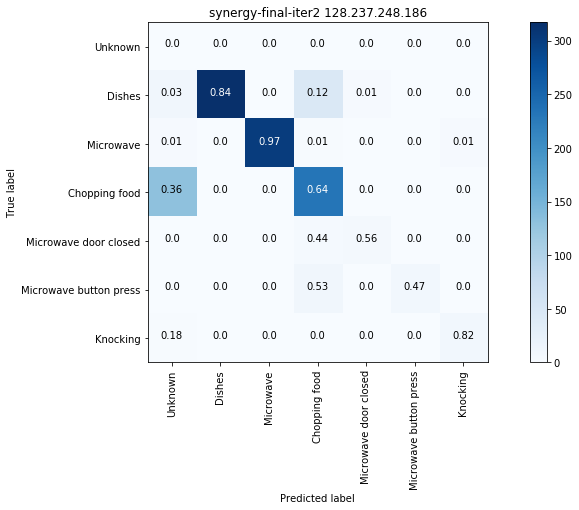

synergy-final-iter1 128.237.254.195 0 MICROPHONE_|microphone SVM
synergy-final-iter5 128.237.250.218 7 MICROPHONE|microphone|ACCEL_|accel_ LogisticRegression
synergy-final-iter2 128.237.254.195 11 MICROPHONE_|microphone LogisticRegression
synergy-final-iter1 128.237.254.195 1 MICROPHONE_|microphone SVM
synergy-final-iter5 128.237.250.218 18 ACCEL_|accel_|mag_ LogisticRegression
synergy-final-iter2 128.237.254.195 14 MICROPHONE_|microphone SVM

synergy-final-iter1 128.237.246.127 0.916666666667 0.969696969697


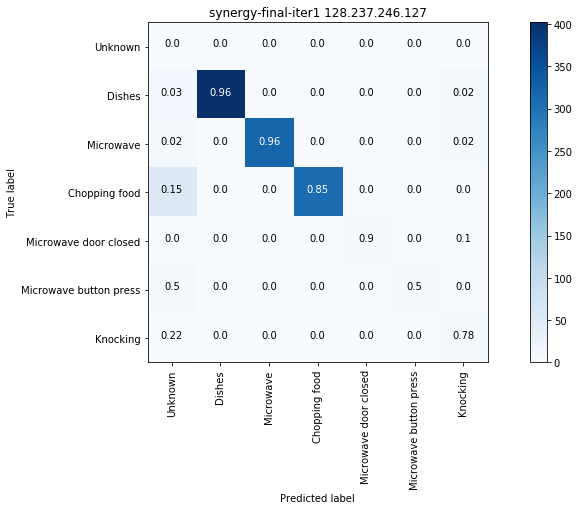

synergy-final-iter5 128.237.227.76 11 MICROPHONE_|microphone LogisticRegression
synergy-final-iter2 128.237.254.195 7 MICROPHONE_|microphone SVM
scott-final-iter1 128.237.247.134 0 MICROPHONE|microphone|ACCEL_|accel_ LogisticRegression
synergy-final-iter5 128.237.227.76 1 MICROPHONE|microphone|ACCEL_|accel_ SVM
synergy-final-iter4 128.237.250.218 18 MICROPHONE|microphone|ACCEL_|accel_ LogisticRegression
synergy-final-iter1 128.237.248.186 14 MICROPHONE_|microphone SVM

robotics-final 128.237.248.186 0.942307692308 0.977207977208


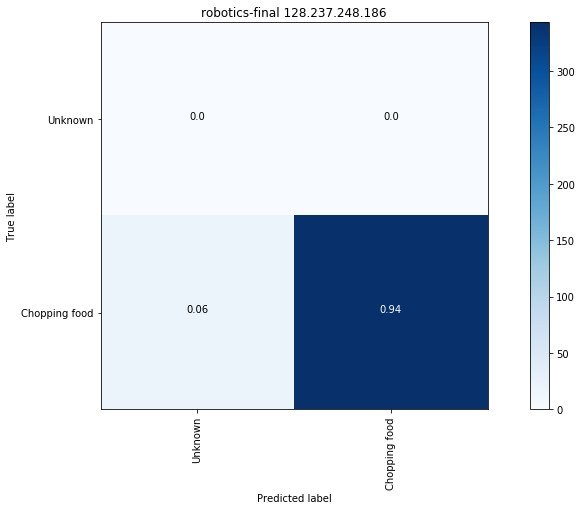

robotics-final 128.237.246.127 7 MICROPHONE_|microphone RandomForestClassifier

scott-final-iter1 128.237.246.127 0.203576341128 0.469841269841


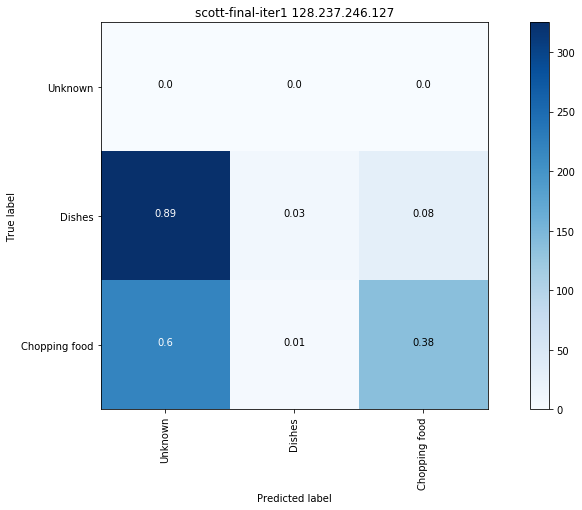

synergy-final-iter5 128.237.227.76 0 MICROPHONE|microphone|ACCEL_|accel_ LogisticRegression
synergy-final-iter2 128.237.254.195 7 MICROPHONE_|microphone SVM

synergy-final-iter5 128.237.247.190 0.702479338843 0.917774086379


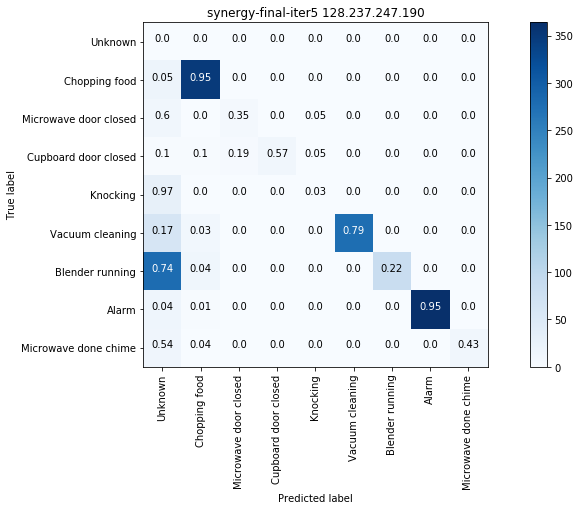

synergy-final-iter4 128.237.247.190 7 MICROPHONE_|microphone LogisticRegression
synergy-final-iter4 128.237.250.218 25 MICROPHONE_|microphone LogisticRegression
synergy-final-iter4 128.237.250.218 21 .* SVM
synergy-final-iter1 128.237.248.186 11 MICROPHONE_|microphone SVM
synergy-final-iter5 128.237.250.218 23 MICROPHONE_|microphone SVM
synergy-final-iter5 128.237.250.218 22 MICROPHONE|microphone|ACCEL_|accel_ RandomForestClassifier
synergy-final-iter1 128.237.248.186 18 MICROPHONE|microphone|ACCEL_|accel_ LogisticRegression
synergy-final-iter5 128.237.250.218 13 MICROPHONE_|microphone LogisticRegression

synergy-final-iter2 128.237.246.127 0.523932729625 0.709281961471


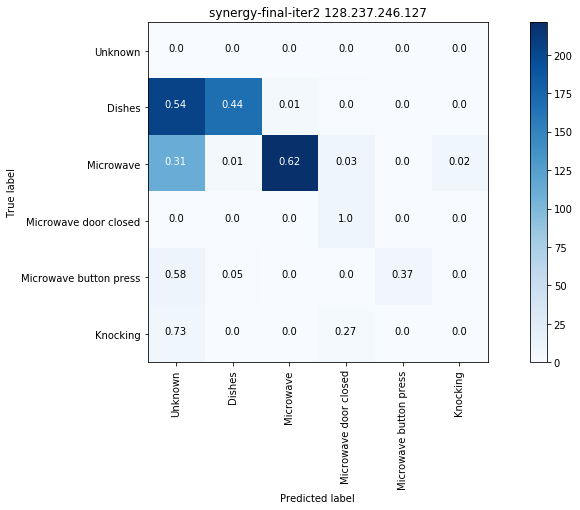

synergy-final-iter1 128.237.248.186 11 MICROPHONE_|microphone LogisticRegression
robotics-final 128.237.246.127 0 MICROPHONE|microphone|ACCEL_|accel_ LogisticRegression
synergy-final-iter1 128.237.248.186 1 MICROPHONE_|microphone LogisticRegression
synergy-final-iter1 128.237.248.186 18 MICROPHONE|microphone|ACCEL_|accel_ LogisticRegression
synergy-final-iter2 128.237.254.195 14 MICROPHONE_|microphone SVM

synergy-final-iter5 128.237.250.218 0.88747645951 0.901913875598


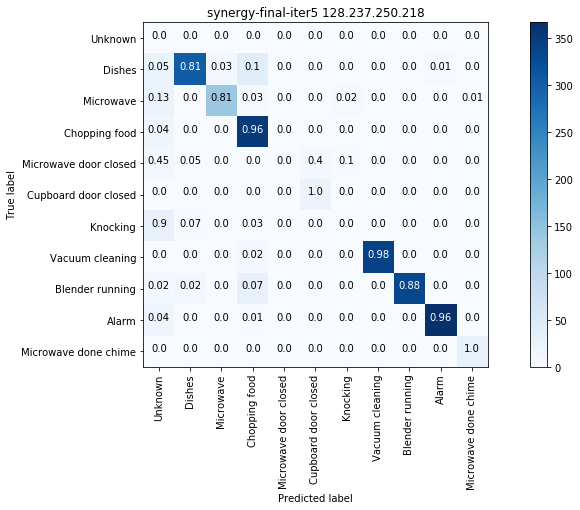

synergy-final-iter4 128.237.247.190 0 MICROPHONE_|microphone LogisticRegression
synergy-final-iter4 128.237.247.190 7 MICROPHONE_|microphone LogisticRegression
synergy-final-iter4 128.237.250.218 23 MICROPHONE_|microphone SVM
synergy-final-iter4 128.237.250.218 21 MICROPHONE_|microphone SVM
synergy-final-iter4 128.237.250.218 11 ACCEL_|accel_|mag_ RandomForestClassifier
synergy-final-iter4 128.237.250.218 25 MICROPHONE_|microphone SVM
synergy-final-iter1 128.237.254.195 1 MICROPHONE_|microphone SVM
synergy-final-iter4 128.237.247.190 22 MICROPHONE_|microphone SVM
synergy-final-iter2 128.237.248.186 18 MICROPHONE|microphone|ACCEL_|accel_ LogisticRegression
synergy-final-iter4 128.237.247.190 13 MICROPHONE_|microphone SVM

synergy-final-iter2 128.237.254.195 0.872994652406 0.922316384181


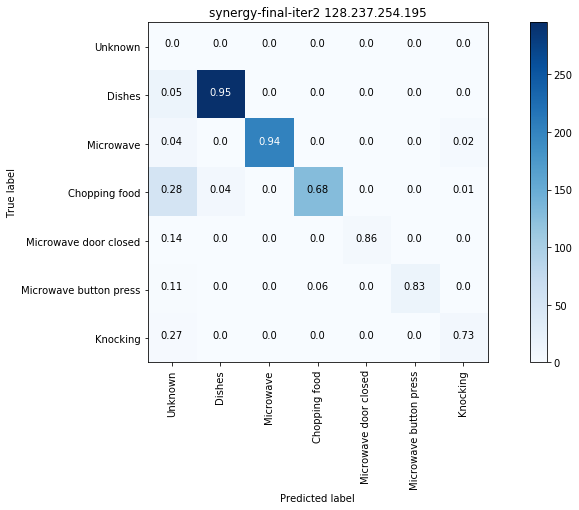

synergy-final-iter1 128.237.248.186 0 MICROPHONE|microphone|ACCEL_|accel_ SVM
synergy-final-iter5 128.237.227.76 7 MICROPHONE_|microphone SVM
synergy-final-iter4 128.237.250.218 11 MICROPHONE_|microphone SVM
synergy-final-iter5 128.237.227.76 1 MICROPHONE|microphone|ACCEL_|accel_ SVM
synergy-final-iter5 128.237.227.76 18 MICROPHONE|microphone|ACCEL_|accel_ LogisticRegression
synergy-final-iter1 128.237.248.186 14 MICROPHONE_|microphone SVM

synergy-final-iter4 128.237.247.190 0.774896876841 0.874916833001


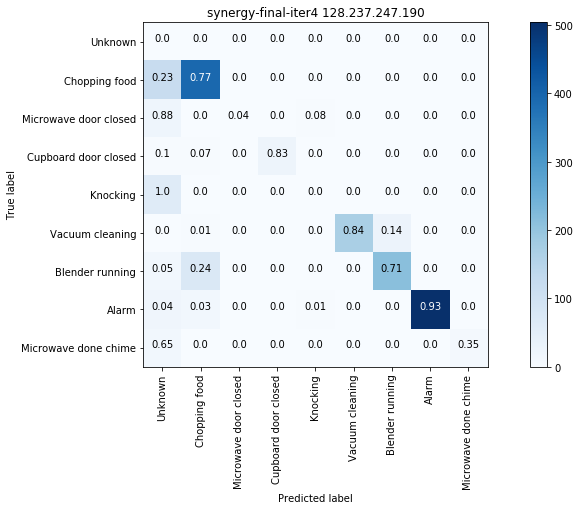

synergy-final-iter5 128.237.250.218 7 MICROPHONE_|microphone LogisticRegression
synergy-final-iter4 128.237.250.218 25 MICROPHONE_|microphone SVM
synergy-final-iter4 128.237.250.218 21 MICROPHONE_|microphone SVM
synergy-final-iter1 128.237.248.186 11 MICROPHONE_|microphone SVM
synergy-final-iter5 128.237.250.218 23 MICROPHONE|microphone|ACCEL_|accel_ SVM
synergy-final-iter5 128.237.250.218 22 MICROPHONE|microphone|ACCEL_|accel_ SVM
synergy-final-iter1 128.237.248.186 18 MICROPHONE|microphone|ACCEL_|accel_ LogisticRegression
synergy-final-iter4 128.237.250.218 13 MICROPHONE_|microphone LogisticRegression

synergy-final-iter4 128.237.227.76 0.826037735849 0.893834218048


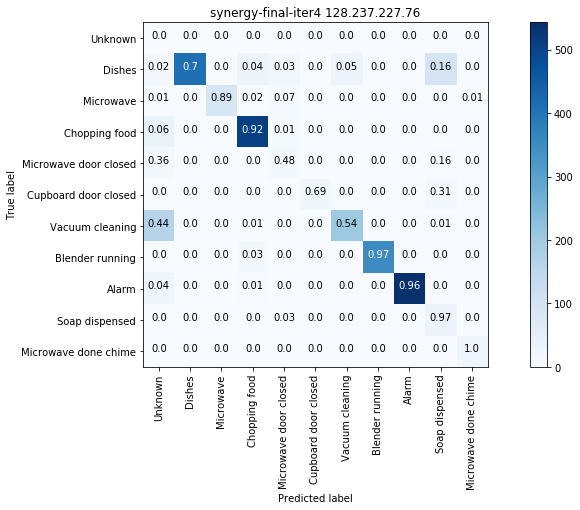

synergy-final-iter5 128.237.250.218 24 .* LogisticRegression
synergy-final-iter4 128.237.247.190 7 MICROPHONE_|microphone LogisticRegression
synergy-final-iter4 128.237.250.218 25 MICROPHONE_|microphone SVM
synergy-final-iter5 128.237.227.76 21 .* RandomForestClassifier
synergy-final-iter5 128.237.250.218 0 MICROPHONE_|microphone SVM
synergy-final-iter5 128.237.227.76 23 .* SVM
synergy-final-iter5 128.237.227.76 1 MICROPHONE_|microphone SVM
synergy-final-iter4 128.237.247.190 22 MICROPHONE_|microphone SVM
synergy-final-iter5 128.237.250.218 11 .* LogisticRegression
synergy-final-iter5 128.237.250.218 13 .* SVM



In [6]:
for _, case in cases.iterrows():
    # find tests for the case
    case_results = df_results.loc[df_results.target_device == case['device']]
    case_results = case_results.loc[case_results.target_dataset == case['dataset']]

    results_ids = filter_results_by_accuracy(case_results, 'specificity')
    test_results = [all_test_results[i] for i in results_ids]
    df = pd.DataFrame([r.predicted for r in test_results]).T
    df.columns = results_ids

    actual = all_test_results[results_ids[0]].actual_with_all_labels
    majority_votes = [majority_vote(row) for i, row in df.iterrows()]

    df['actual'] = actual
    df['majority_votes'] = majority_votes

    can_predict_labels = [r.label for r in test_results]
    df_known_labels = df.loc[df.actual.isin(can_predict_labels)]
    df_all_predicted = df.loc[df.majority_votes != -1]

    accuracy_known_labels = accuracy_score(df_known_labels['actual'], df_known_labels['majority_votes'])
    accuracy_all_predicted = accuracy_score(df_all_predicted['actual'], df_all_predicted['majority_votes'])
    print(case['dataset'], case['device'], accuracy_known_labels, accuracy_all_predicted)
    
    labels = np.sort(np.unique(df_known_labels.actual).tolist())
    labels = [configuration['activities'][i] for i in labels]
    labels = ['Unknown'] + labels
    cm = confusion_matrix(df_known_labels.actual, df_known_labels.majority_votes)
    
    plot_confusion_matrix(cm,
                          labels,
                          normalize=True,
                          title=' '.join([case['dataset'], case['device']]),
                          cmap=plt.cm.Blues)
    
    for result in test_results:
        print(result.source_dataset, result.source_device, result.label, result.features, result.classifier)

    print()

In [43]:
can_predict_labels = [r.label for r in results_by_accuracy]
df_known_labels = df.loc[df.actual.isin(can_predict_labels)]
confusion_matrix(df_known_labels.actual, df_known_labels.majority_votes)

NameError: name 'results_by_accuracy' is not defined